In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import pairwise_distances
import phate
import scprep
from sklearn.decomposition import PCA

os.chdir('../../src')
import mappings
import data_loader

In [2]:
def make_palette_order(labels):
    label_order = np.sort(np.unique(labels))
    
    if len(label_order) <= 10:
        pop_colors = sns.color_palette("tab10")
    else:
        pop_colors = sns.color_palette("viridis", len(label_order))

    pop_pallette = {label:color for label,color in zip(label_order, pop_colors)}
    return label_order, pop_pallette

In [3]:
# Load MHI
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/CaG/gsa.17k'
fname = 'gsa.17k.final.WR_hg38-updated.missing10perc.noMAF0.common1000G.noHLA.hdf5'
metadata_file = 'MHI_poplabels.tsv'
data_path = os.path.join(exp_path, fname)
metadata_path = os.path.join(exp_path, metadata_file)

with h5py.File(data_path) as f:
    inputs_mhi = f['inputs'][:]
    samples = f['samples'][:]
    class_label_names = f['class_label_names'][:]
    class_labels = f['class_labels'][:]
#pca_input = pd.read_csv('/lustre06/project/6065672/shared/MHI_GWAS_SHUANG/MHI_PCA')

In [4]:
labels = np.array([class_label_names[i] for i in class_labels]).astype('str')

In [5]:
# Severely imbalanced
np.unique(labels, return_counts=True)

(array(['ABORIGINAL', 'ARAB', 'ASIAN', 'BLACK', 'CARIBBEAN', 'LATINO',
        'NA', 'OTHER', 'WHITE'], dtype='<U10'),
 array([  68,  507,  366,  329,   53,  288, 7727,   20, 7928]))

In [6]:
## Load 1000G and fit PCA to it.
# On Compute Canada, Cannot load from drive! Instead load a local copy
def load_from_drive(url):
    # Download the data
    response = requests.get(url)
    data = response.content

    # Load into a DataFrame
    df = pd.read_csv(BytesIO(data))
    df.set_index('Unnamed: 0', inplace=True)
    return df

# Download data and metadata from direct download links
#inputs = load_from_drive('https://drive.google.com/uc?export=download&id=1HjK4lGImHr1WKDaz3me8Jj7FJ72S0WzL')
#labels = load_from_drive('https://drive.google.com/uc?export=download&id=1egE-5_MaCbTjQeJn6fbogcBjlXAsxSrg')
#admix_ratios = load_from_drive('https://drive.google.com/uc?export=download&id=1mYHRCkToVDa2S0cQXKlHzKHDBqb75ozC')

def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs_1K = load_from_local('../data/1000G/1000G_PCA')
labels_1K = load_from_local('../data/1000G/1000G_labels')
admix_ratios_1K = load_from_local('../data/1000G/1000G_admix_ratios')

exp_path_1K = '/lustre06/project/6065672/sciclun4/ActiveProjects/phate_genetics/data/1000G'
fname_1K = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed.hdf5'
inputs_raw_1K, _, samples_1K, snp_name_1Ks, _ = data_loader.load_data_1000G(os.path.join(exp_path_1K, fname_1K))

In [7]:
# Fit PCA model
pca_1K = PCA(n_components=100)  # Number of components to keep
pca_1K.fit(inputs_raw_1K)
pca_input_1K = pca_1K.transform(inputs_raw_1K)

# Approach 1

Project MHI onto 1KGP (In PC Space + PHATE Space)

In [8]:
inputs_raw_1K.shape, inputs_mhi.shape

((2504, 229986), (17286, 229986))

In [19]:
inputs_mhi[:2,:].shape

(2, 229986)

In [38]:
# Project MHI onto 1000G
pca_input_mhi = []
for i in range((inputs_mhi.shape[0]//1000)+1):
    start = i*1000
    end = (i+1)*1000
    pca_input_mhi.append(pca_1K.transform(inputs_mhi[start:end,:]))
pca_input_mhi = np.concatenate(pca_input_mhi)

In [45]:
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input_1K)
phate_emb_1K = phate_operator.transform(pca_input_1K)

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.37 seconds.
  Calculating affinities...
  Calculated affinities in 0.12 seconds.
Calculated graph and diffusion operator in 0.52 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.14 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.11 seconds.
Calculated landmark operator in 1.90 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.71 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.03 seconds.


In [46]:
phate_emb_mhi = phate_operator.transform(pca_input_mhi)

Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 2.36 seconds.
Calculating affinities...
Calculated affinities in 1.47 seconds.


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/scprep/plot/scatter.py:438: UserWarning: Cannot create a legend with constant `c=black`
  warnings.warn(


<Axes: title={'center': 'PHATE Plot'}>

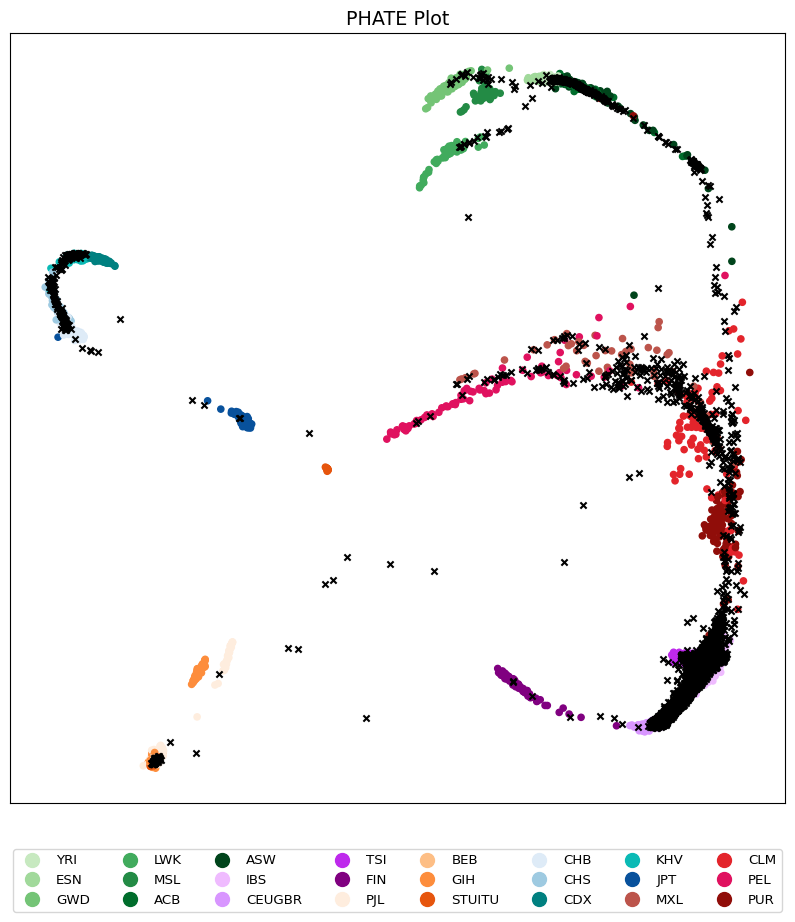

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_1K, s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

scprep.plot.scatter2d(phate_emb_mhi, c='black', marker='x', s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

<Axes: title={'center': 'PHATE Plot'}>

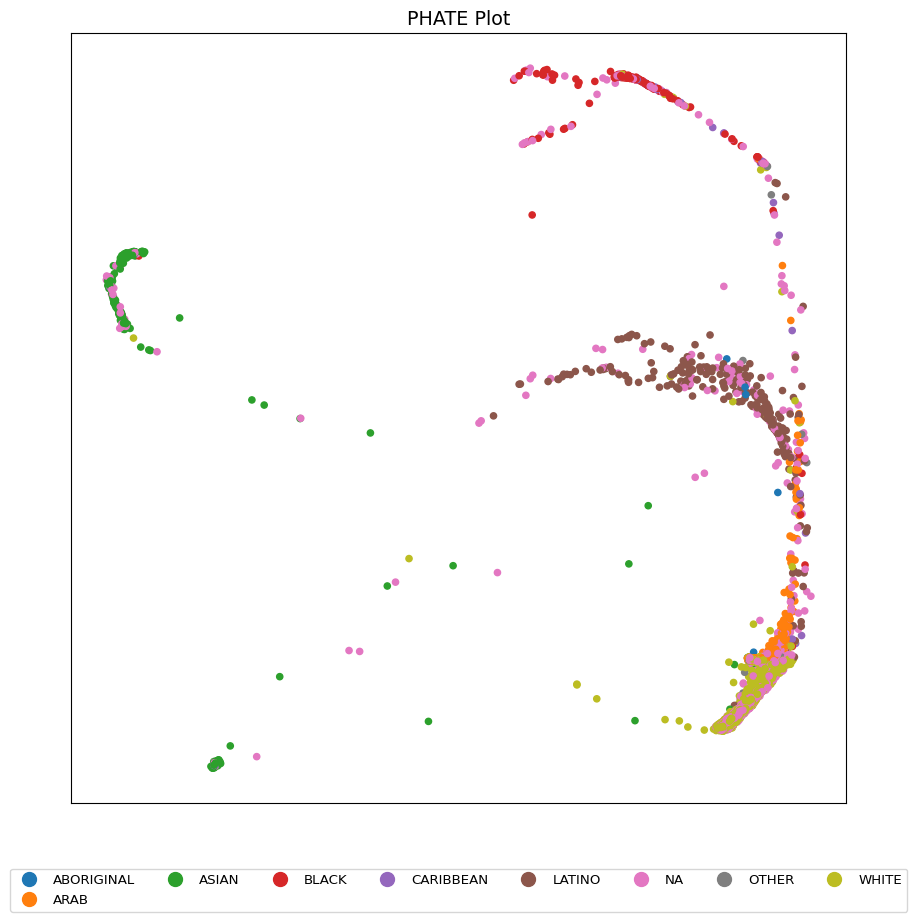

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_mhi, c=labels, s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',
                      fontsize=8)

# PHATE on PC-projected MHI

In [50]:
phate_operator2 = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator2.fit(pca_input_mhi)
phate_emb_mhi2 = phate_operator2.transform(pca_input_mhi)

Running PHATE on 17286 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 20.14 seconds.
  Calculating affinities...
  Calculated affinities in 15.69 seconds.
Calculated graph and diffusion operator in 35.87 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 1.70 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.40 seconds.
Calculated landmark operator in 5.42 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.05 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.35 seconds.


<Axes: title={'center': 'PHATE Plot'}>

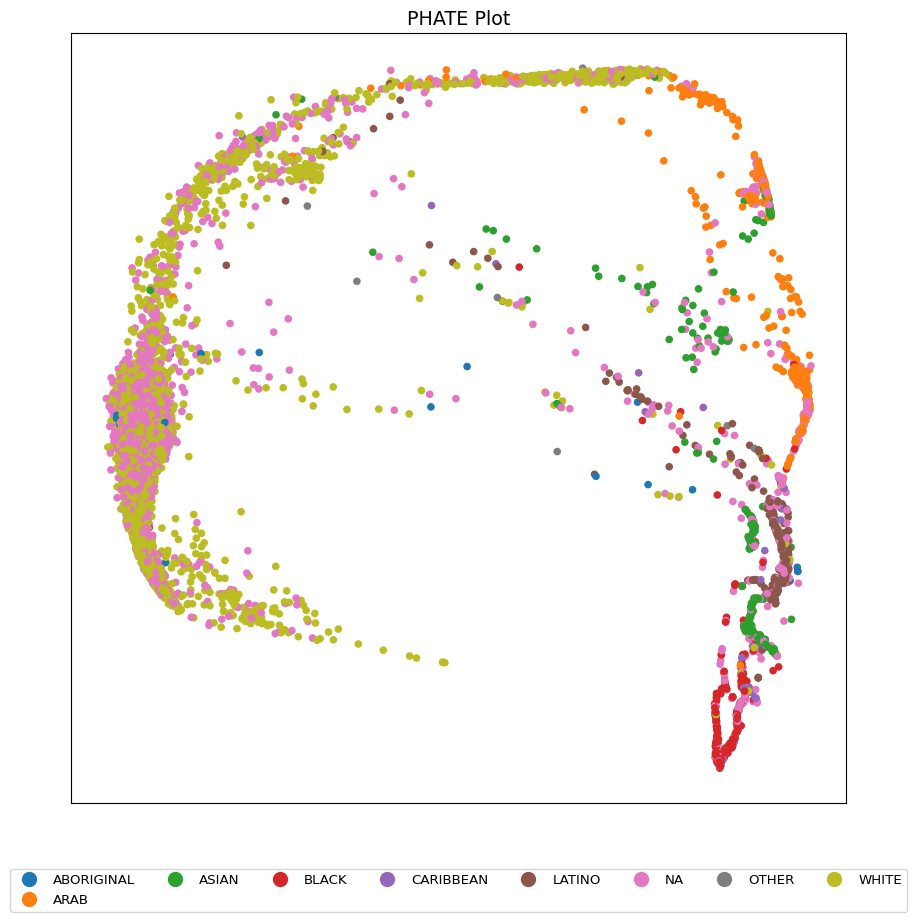

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_mhi2, c=labels, s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',
                      fontsize=8)

# PCA+PHATE on just MHI

In [9]:
r_idx = np.random.choice(inputs_mhi.shape[0], 5000, replace=False)

In [12]:
# Project MHI onto 1000G
# Fit PCA model
pca_mhi = PCA(n_components=50)  # Number of components to keep
pca_mhi.fit(inputs_mhi[r_idx])

pca_input_mhi2 = []
for i in range((inputs_mhi.shape[0]//1000)+1):
    start = i*1000
    end = (i+1)*1000
    pca_input_mhi2.append(pca_mhi.transform(inputs_mhi[start:end,:]))
pca_input_mhi2 = np.concatenate(pca_input_mhi2)

In [13]:
phate_operator3 = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator3.fit(pca_input_mhi2)
phate_emb_mhi3 = phate_operator3.transform(pca_input_mhi2)

Running PHATE on 17286 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 11.35 seconds.
  Calculating affinities...
  Calculated affinities in 3.02 seconds.
Calculated graph and diffusion operator in 14.41 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 1.39 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.60 seconds.
Calculated landmark operator in 5.07 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.06 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.33 seconds.


<Axes: title={'center': 'PHATE Plot'}>

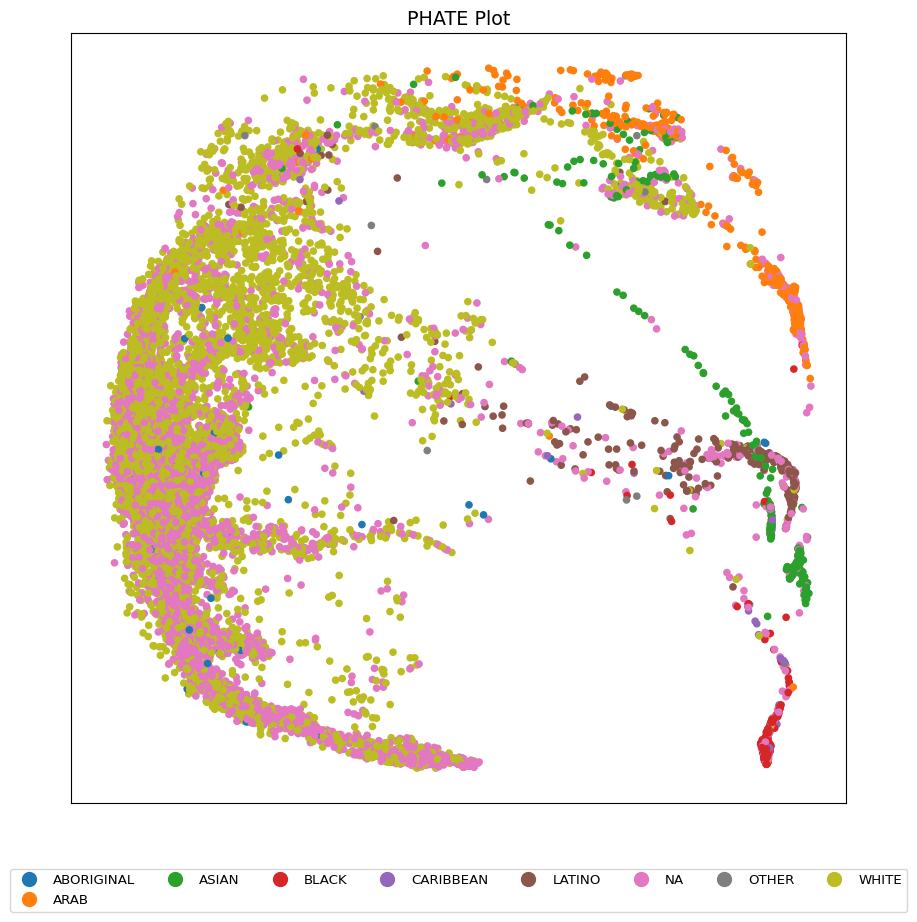

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_mhi3, c=labels, s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',
                      fontsize=8)